In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
%pip install -U statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
file = Path('Nat_Gas.csv')
df = pd.read_csv(file)
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


Text(0.5, 0, 'Months since start')

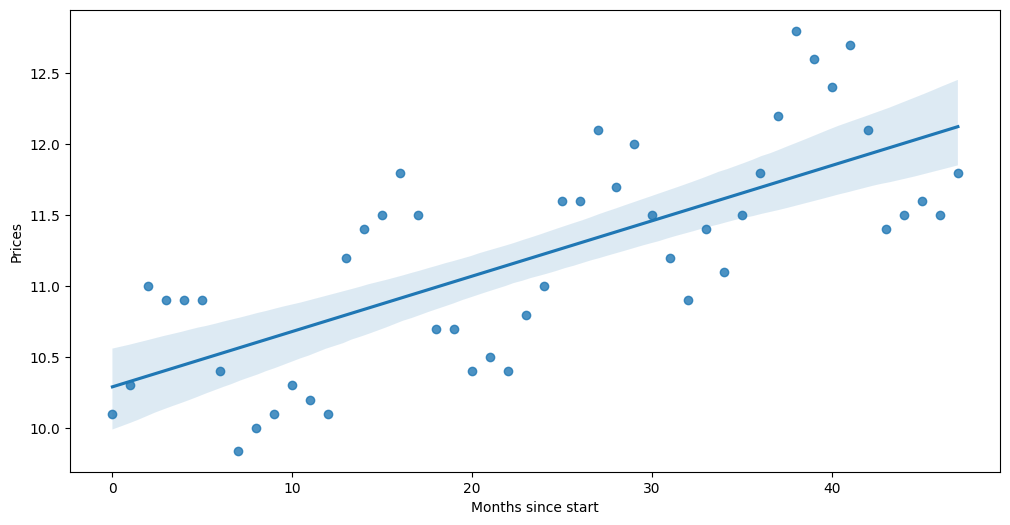

In [24]:
#change the format fort he dates so we can have x and y as float
#also sort months counting from the start date
df = df.sort_values('Dates')
m = df['Dates'].dt.year * 12 + df['Dates'].dt.month
t = (m - m.min()).to_numpy().astype(float)  
y = df['Prices'].to_numpy().astype(float)

plt.figure(figsize = (12,6))
sns.regplot(data = df,x = t, y = 'Prices' )
plt.xlabel('Months since start')

In [26]:
#Task 1 - price prediction and fitting
from scipy.optimize import curve_fit

# model: constant + linear + quadratic + yearly sine/cosine
# we can see clear linear fuction a + b*t, however on the edges the CI looks bigger so let's try to see if t^2
#going to be needed. 
#--------------------------
# sin & cos give us a smooth seasonal shape with one peak and one trough per year, 
#which is exactly what heating-driven gas demand suggests from the report.
def f(t, a, b, c, d, e):
    P = 12.0
    return a + b*t + e*t*t + c*np.sin(2*np.pi*t/P) + d*np.cos(2*np.pi*t/P)

popt, _ = curve_fit(f, t, y, maxfev=20000)
a, b, c, d, e = popt #finding weights

print(f"f(t) = {a:.4f} + {b:.4f}·t + {e:.10f}·t² + {c:.4f}·sin(2π·t/12) + {d:.4f}·cos(2π·t/12)")
# t = months since the first date

f(t) = 10.1233 + 0.0471·t + -0.0000322644·t² + 0.6900·sin(2π·t/12) + -0.0374·cos(2π·t/12)


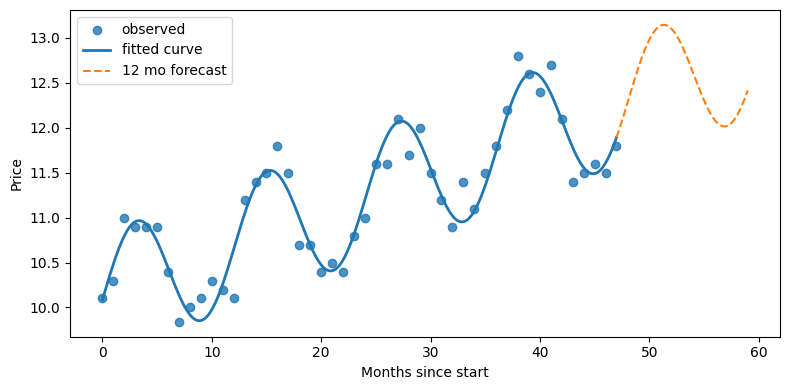

In [27]:
#scatter of the original points (t = months since start)
plt.figure(figsize=(8,4))
plt.scatter(t, y, label="observed", alpha=0.8)

#smooth fitted curve over the observed range
t_grid = np.linspace(t.min(), t.max(), 400)
y_grid = f(t_grid, *popt)
plt.plot(t_grid, y_grid, label="fitted curve", linewidth=2)

# extend 12 months into the future
t_future = np.linspace(t.max(), t.max() + 12, 240)
y_future = f(t_future, *popt)
plt.plot(t_future, y_future, linestyle="--", label="12 mo forecast")

plt.xlabel("Months since start")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = f(t,*popt)
residuals = y - y_pred

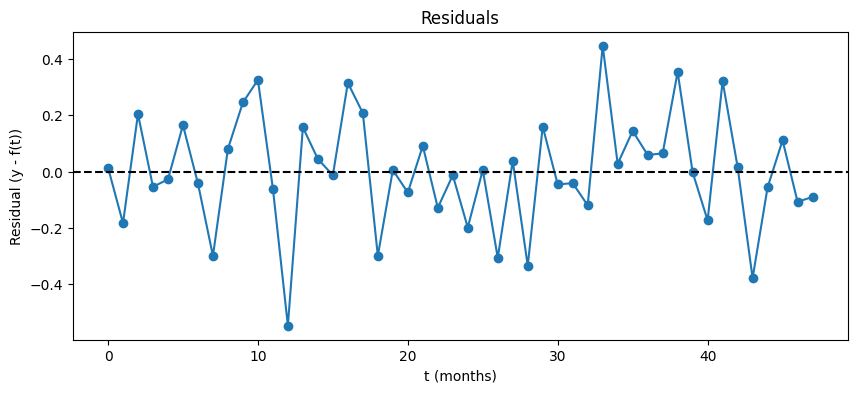

In [31]:
plt.figure(figsize=(10,4))
plt.plot(t, residuals, 'o-')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('t (months)')
plt.ylabel('Residual (y - f(t))')
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(y, y_pred))

In [33]:
rmse

0.1996950561698894

In [37]:
from datetime import datetime
reference_date = datetime(2020, 10, 31)

def get_price_for_date(input_date_str):
    
    # Convert string to datetime if needed
    if isinstance(input_date_str, str):
        input_date = datetime.strptime(input_date_str, '%Y-%m-%d')
    else:
        input_date = input_date_str
    
    # Calculate months since reference date
    months_diff = (input_date.year - reference_date.year) * 12 + (input_date.month - reference_date.month)
    
    # Add fractional month based on day
    months_diff += (input_date.day - reference_date.day) / 30.44  # average days per month
    
    # Calculate price using your fitted model
    price = f(months_diff, a, b, c, d, e)
    
    return price

# Example usage:
user_date = input("Enter date (YYYY-MM-DD): ")
predicted_price = get_price_for_date(user_date)
print(f"Predicted price for {user_date}: {predicted_price:.2f}")

Enter date (YYYY-MM-DD):  2025-8-12


Predicted price for 2025-8-12: 12.04


In [59]:
#Volumes checker
def volume_checker(user_Injections_date, user_Injections_volume, user_Withdrawals_date, user_Withdrawals_volume,user_max_volume):
    
    injection_data = pd.DataFrame({'Date': user_Injections_date,'Volume': user_Injections_volume,'Type': 'Injection'})
    withdrawal_data = pd.DataFrame({'Date': user_Withdrawals_date,'Volume': -user_Withdrawals_volume,'Type': 'Withdrawal'})

    # Combine and sort by date
    dates_volumes = pd.concat([injection_data, withdrawal_data], axis=0)
    dates_volumes['Date'] = pd.to_datetime(dates_volumes['Date'])  
    dates_volumes = dates_volumes.sort_values(by='Date', ascending=True).reset_index(drop=True)
    # Check volume capacity
    current_volume = 0
    capacity_ok = True
    print("VOLUME CAPACITY VERIFICATION")
    print("="*70)

    for i in range(len(dates_volumes)):
        row = dates_volumes.iloc[i]
        current_volume += row['Volume']
    
        print(f"{row['Date']} | {row['Type']:11} | Volume: {row['Volume']:>10,.2f} | Current: {current_volume:>10,.2f}")
    
        if current_volume > user_max_volume:
            print(f"\n Exceeded storage capacity on {row['Date']}")
            print(f"Current volume: {current_volume:,.2f} > Max capacity: {user_max_volume:,.2f}")
            capacity_ok = False
            break
        elif current_volume < 0:
            print(f"\n Insufficient stock on {row['Date']}")
            print(f"Trying to withdraw more than available. Current volume: {current_volume:,.2f}")
            capacity_ok = False
            break

    if capacity_ok:
        print("\n Volume checker status: SUCCESS")
        print(f"Peak storage used: {dates_volumes['Volume'].cumsum().max():,.2f} / {user_max_volume:,.2f}")
        print("="*70 + "\n")
    else:
        print("="*70 + "\n")

In [60]:
#Injections
user_Injections = int(input('Please enter the number of the injection: '))
user_Injections_date = np.empty(user_Injections, dtype='object')
user_Injections_volume = np.zeros(user_Injections)

for i in range(user_Injections):
    user_Injections_date[i] = input(f"Enter the date of the {i+1} injection (YYYY-MM-DD): ")
    user_Injections_volume[i] = float(input(f"Enter the volume of the {i+1} injection: "))

#Withdrawals
user_Withdrawals = int(input('Please enter the number of the withdrawals: '))
user_Withdrawals_date = np.empty(user_Withdrawals, dtype='object')
user_Withdrawals_volume = np.zeros(user_Withdrawals)

for w in range(user_Withdrawals):
    user_Withdrawals_date[w] = input(f"Enter date of the {w+1} withdrawal (YYYY-MM-DD): ")
    user_Withdrawals_volume[w] = float(input(f"Enter the volume of the {w+1} withdrawal: "))

#Max Volume
user_max_volume = float(input("Enter the maximum volume that can be stored: "))

user_storage_cost = float(input("Enter the total storage cost: "))

#Predciting prices
predicted_injection_prices = np.zeros(user_Injections)
predicted_withdrawal_prices = np.zeros(user_Withdrawals)

for i in range(user_Injections):
    predicted_injection_prices[i] = get_price_for_date(user_Injections_date[i])
for w in range(user_Withdrawals):
    predicted_withdrawal_prices[w] = get_price_for_date(user_Withdrawals_date[w])

Injection_Prices_total = predicted_injection_prices * user_Injections_volume
Withdrawals_Prices_total = predicted_withdrawal_prices * user_Withdrawals_volume

# For injections
Injections_df = pd.DataFrame({'Date': user_Injections_date, 'Price': predicted_injection_prices,
                             'Volume':user_Injections_volume,'Total': Injection_Prices_total})


# For withdrawals
Withdrawals_df = pd.DataFrame({'Date': user_Withdrawals_date,'Price': predicted_withdrawal_prices,
                             'Volume': user_Withdrawals_volume,'Total': Withdrawals_Prices_total})

#check if 0 < current volume for each date < max storage capacity 
volume_checker(user_Injections_date, user_Injections_volume, user_Withdrawals_date, user_Withdrawals_volume, user_max_volume)



print("="*70)
print("\n","INJECTIONS:","\n", Injections_df,"\n","\n", "Total:", Injection_Prices_total.sum())
print("="*70)
print("\n","WITHDRAWALS:","\n", Withdrawals_df,"\n","\n","Total:", Withdrawals_Prices_total.sum())
print("="*70)
contract_price = Withdrawals_Prices_total.sum() - Injection_Prices_total.sum() - user_storage_cost
print("\n","\n","CONTRACT PRICE:", contract_price )



Please enter the number of the injection:  2
Enter the date of the 1 injection (YYYY-MM-DD):  2022-11-09
Enter the volume of the 1 injection:  1000
Enter the date of the 2 injection (YYYY-MM-DD):  2023-04-05
Enter the volume of the 2 injection:  500
Please enter the number of the withdrawals:  2
Enter date of the 1 withdrawal (YYYY-MM-DD):  2023-01-21
Enter the volume of the 1 withdrawal:  600
Enter date of the 2 withdrawal (YYYY-MM-DD):  2024-05-22
Enter the volume of the 2 withdrawal:  700
Enter the maximum volume that can be stored:  1800
Enter the total storage cost:  20


VOLUME CAPACITY VERIFICATION
2022-11-09 00:00:00 | Injection   | Volume:   1,000.00 | Current:   1,000.00
2023-01-21 00:00:00 | Withdrawal  | Volume:    -600.00 | Current:     400.00
2023-04-05 00:00:00 | Injection   | Volume:     500.00 | Current:     900.00
2024-05-22 00:00:00 | Withdrawal  | Volume:    -700.00 | Current:     200.00

 Volume checker status: SUCCESS
Peak storage used: 1,000.00 / 1,800.00


 INJECTIONS: 
          Date      Price  Volume         Total
0  2022-11-09  11.311488  1000.0  11311.488056
1  2023-04-05  11.801970   500.0   5900.985158 
 
 Total: 17212.4732144074

 WITHDRAWALS: 
          Date      Price  Volume        Total
0  2023-01-21  12.031009   600.0  7218.605119
1  2024-05-22  11.863760   700.0  8304.631871 
 
 Total: 15523.236989844407

 
 CONTRACT PRICE: -1709.2362245629938
